# Detecting Pneumonia using Convolutional Neural Network (CNN)

## Import The Required Libraries

In [130]:
# basics
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

import pickle 

# Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from tensorflow.keras.utils import load_img, img_to_array
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras.backend


## Import The Required Libraries

In [131]:
# basics
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Others
import os
from PIL import Image


## Conduct Simple Exploratory Data Analysis (EDA)

In [132]:
def listdir_nohidden(path):
    return [file for file in os.listdir(path) if not file.startswith('.')]

def num_files_in_directory(path):
    return len([file for file in os.listdir(path) if not file.startswith('.')])

In [133]:
project_path = "D:/Prajyot/Project/Detect-Pneumonia-Using-Deep-Learning-master/chest_xray"
train_path = project_path + "/chest_xray/train/"
val_path = project_path + "/chest_xray/val/"
test_path = project_path + "/chest_xray/test/"

In [134]:
train_normal_path = train_path + 'NORMAL/'
train_pneumonia_path = train_path + 'PNEUMONIA/'
train_normal_len = num_files_in_directory(train_normal_path)
train_pneumonia_len = num_files_in_directory(train_pneumonia_path)
train_sum_len = train_normal_len + train_pneumonia_len

print("[Train] Number of NORMAL Images: ", train_normal_len)
print("[Train] Number of PNEUMONIA Images: ", train_pneumonia_len)
print("[Train] Number of TOTAL Images: ", train_sum_len)

[Train] Number of NORMAL Images:  1341
[Train] Number of PNEUMONIA Images:  3875
[Train] Number of TOTAL Images:  5216


In [135]:
val_normal_path = val_path + 'NORMAL/'
val_pneumonia_path = val_path + 'PNEUMONIA/'

print("[Validation] Number of NORMAL Images: ", num_files_in_directory(val_normal_path))
print("[Validation] Number of PNEUMONIA Images: ", num_files_in_directory(val_pneumonia_path))
print("[Validation] Number of TOTAL Images: ", num_files_in_directory(val_normal_path) + num_files_in_directory(val_pneumonia_path))

[Validation] Number of NORMAL Images:  8
[Validation] Number of PNEUMONIA Images:  8
[Validation] Number of TOTAL Images:  16


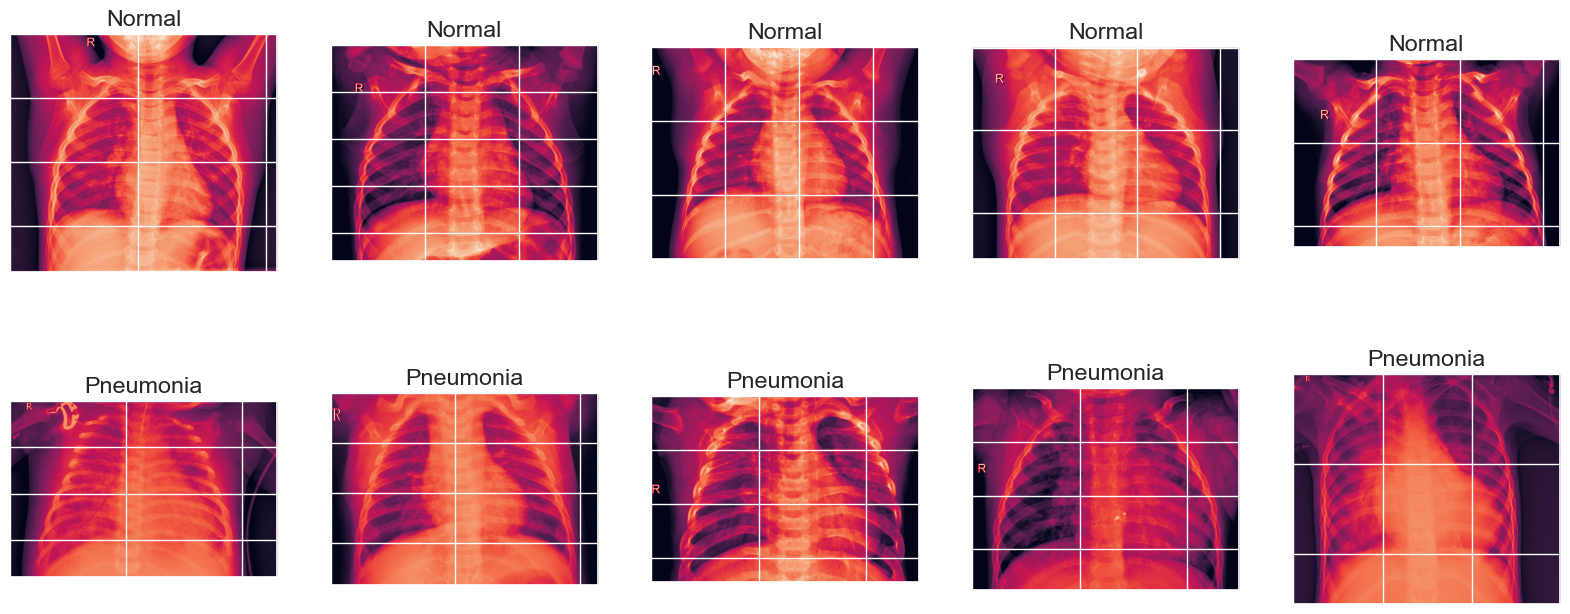

In [136]:
def listdir_nohidden_images(path, valid_extensions=('jpg', 'jpeg', 'png')):
    return [
        file for file in os.listdir(path)
        if not file.startswith('.') and file.split('.')[-1].lower() in valid_extensions
    ]

plt.figure(figsize=(20, 8))
num = 5
train_normal_files = listdir_nohidden_images(train_normal_path)
train_pneumonia_files = listdir_nohidden_images(train_pneumonia_path)

for index in range(num):
    n_img_title = train_normal_files[index]
    n_img_path = train_normal_path + n_img_title
    
    plt.subplot(2, num, index+1)
    plt.imshow(Image.open(n_img_path))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)
    plt.title('Normal');
    
    p_img_title = train_pneumonia_files[index]
    p_img_path = train_pneumonia_path + p_img_title
    
    plt.subplot(2, num, index+num+1)
    plt.imshow(Image.open(p_img_path))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)
    plt.title('Pneumonia');

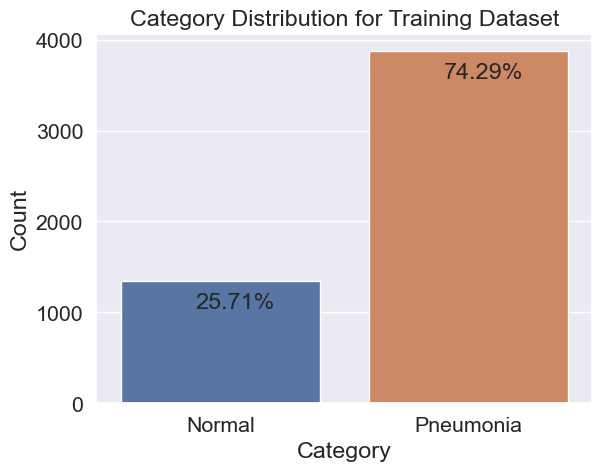

In [137]:
# Create the list of counts and percentages
count_list = [
    ['Normal', train_normal_len, train_normal_len/train_sum_len],
    ['Pneumonia', train_pneumonia_len, train_pneumonia_len/train_sum_len]
]

# Create a DataFrame from the list
count_df = pd.DataFrame(count_list, columns=['Category', 'Count', 'Percentage'])

# Extract values for bar plot
values = [train_normal_len, train_pneumonia_len]

# Plot the bar chart
ax = sns.barplot(x='Category', y='Count', data=count_df)
ax.set_title("Category Distribution for Training Dataset")

# Add percentage text above the bars
for index, value in enumerate(values):
    plt.text(index - 0.1, value - 300, str(round(value / sum(values) * 100, 2)) + "%")

plt.show()


I notice that all images are in different sizes.

In [138]:
for index in range(20):  
    sample_image = train_normal_path + listdir_nohidden(train_normal_path)[index]
    image = Image.open(sample_image)
    width, height = image.size
    print('image', index+1, ':', width, 'x', height)

image 1 : 2090 x 1858
image 2 : 1422 x 1152
image 3 : 1810 x 1434
image 4 : 1618 x 1279
image 5 : 1600 x 1125
image 6 : 1974 x 1306
image 7 : 1528 x 1013
image 8 : 1384 x 1167
image 9 : 1450 x 1144
image 10 : 1468 x 993
image 11 : 1724 x 1581
image 12 : 1346 x 1044
image 13 : 1156 x 1237
image 14 : 1740 x 1453
image 15 : 2138 x 1928
image 16 : 1596 x 1156
image 17 : 2102 x 1974
image 18 : 1542 x 1152
image 19 : 1518 x 1156
image 20 : 1612 x 1133


In [139]:
hyper_dimension = 64
hyper_epochs = 100
hyper_feature_maps = 32
hyper_batch_size = 128

## Training in grayscale instead of RGB
hyper_channels = 1
hyper_mode = 'grayscale'


In [140]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range=0.2,
                                   zoom_range=0.2, 
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 

train_generator = train_datagen.flow_from_directory(directory=train_path, 
                                                    target_size=(hyper_dimension, hyper_dimension),
                                                    batch_size=hyper_batch_size, 
                                                    color_mode=hyper_mode,
                                                    class_mode='binary', 
                                                    seed=42)
val_generator = val_datagen.flow_from_directory(directory=val_path, 
                                                 target_size=(hyper_dimension, hyper_dimension),
                                                 batch_size=hyper_batch_size, 
                                                 class_mode='binary',
                                                 color_mode=hyper_mode,
                                                 shuffle=False,
                                                 seed=42)
test_generator = test_datagen.flow_from_directory(directory=test_path, 
                                                  target_size=(hyper_dimension, hyper_dimension),
                                                  batch_size=hyper_batch_size, 
                                                  class_mode='binary',
                                                  color_mode=hyper_mode,
                                                  shuffle=False,
                                                  seed=42)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [141]:
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

if tf.__version__.startswith('1.'):
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    from keras import backend as K
    K.set_session(sess)


In [142]:
project_path = "D:/Prajyot/Project/Detect-Pneumonia-Using-Deep-Learning-master/chest_xray"
train_path = project_path + "/chest_xray/train/"
val_path = project_path + "/chest_xray/val/"
test_path = project_path + "/chest_xray/test/"

In [143]:
hyper_dimension = 64
hyper_batch_size = 128
hyper_epochs = 100

## Training in grayscale instead of RGB
hyper_channels = 1
hyper_mode = 'grayscale'

In [144]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 


train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size, 
                                                    color_mode = hyper_mode,
                                                    class_mode = 'binary', 
                                                    seed = 42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)

test_generator.reset()

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Top 3 Models

We first created a function to create two charts that shows the progress of training the neural network.

In [145]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps=len(test_generator))  # Use predict instead of predict_generator
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2, 2, 1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2, 2, 2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2, 2, 3)
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    ticklabels = ['Normal', 'Pneumonia']

    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14)
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2, 2, 4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc * 100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / np.sum(cm)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1 = 2 * precision * recall / (precision + recall)
    stats_summary = (
        '[Summary Statistics]\n'
        f'Accuracy = {accuracy:.2%} | Precision = {precision:.2%} | '
        f'Recall = {recall:.2%} | Specificity = {specificity:.2%} | F1 Score = {f1:.2%}'
    )
    print(stats_summary)


### Model #1: Conv2D x 3 + 64 dense units

In [146]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))
                                
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1
)



c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - auc_27: 0.5042 - loss: 0.5950 - val_auc_27: 0.6406 - val_loss: 0.6869
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_27: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - auc_27: 0.8271 - loss: 0.4478 - val_auc_27: 0.8594 - val_loss: 0.4863
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_27: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - auc_27: 0.9435 - loss: 0.2692 - val_auc_27: 0.8906 - val_loss: 0.4725
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_27: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - auc_27: 0.9304 - loss: 0.2895 - val_auc_27: 0.9062 - val_loss: 0.4830
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_27: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - auc_27: 0.9622 - loss: 0.2176 - val_auc_27: 0.8750 - val_loss: 0.4371
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_27: 0.0000e+00 - loss: 0.0000e+00


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 860ms/step
[Summary Statistics]
Accuracy = 87.34% | Precision = 91.69% | Recall = 87.69% | Specificity = 86.75% | F1 Score = 89.65%


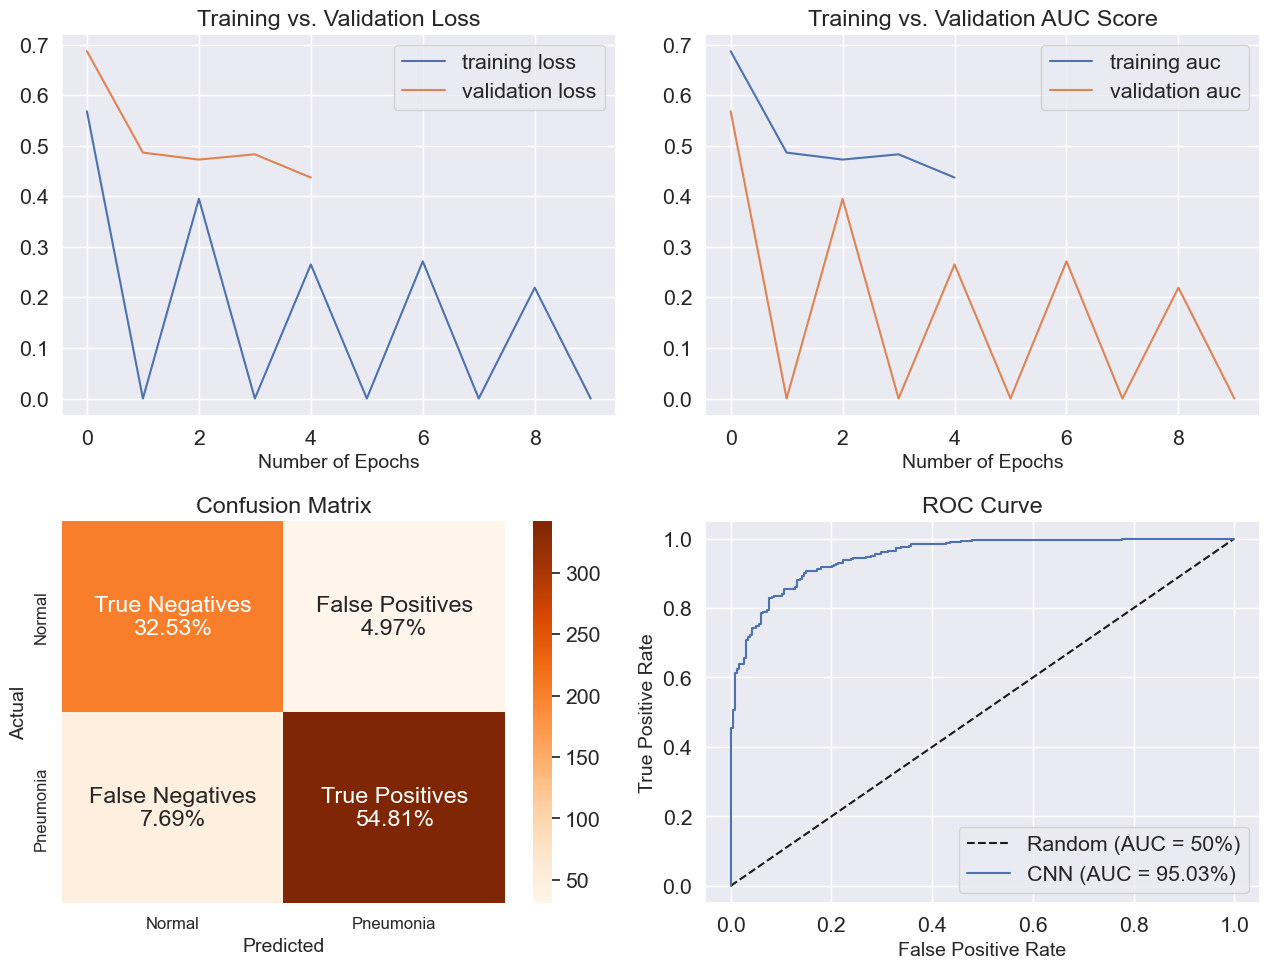

In [147]:
create_charts(cnn, cnn_model)

### Model #2: Conv2D x 4 + 64 dense units

In [148]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

# Replace fit_generator with fit method
cnn_model = cnn.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=10, 
                    validation_data=val_generator,
                    validation_steps=len(val_generator))


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - auc_28: 0.4889 - loss: 0.6060 - val_auc_28: 0.5312 - val_loss: 0.8901
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_28: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - auc_28: 0.7031 - loss: 0.5339 - val_auc_28: 0.8281 - val_loss: 0.6182
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_28: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - auc_28: 0.8984 - loss: 0.3647 - val_auc_28: 0.8516 - val_loss: 1.0909
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_28: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - auc_28: 0.9270 - loss: 0.2991 - val_auc_28: 0.6875 - val_loss: 0.6751
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_28: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 844ms/step - auc_28: 0.9421 - loss: 0.2737 - val_auc_28: 0.7812 - val_loss: 0.6078
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - auc_28: 0.0000e+00 - loss: 0.0000e+00


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step
[Summary Statistics]
Accuracy = 85.10% | Precision = 91.83% | Recall = 83.59% | Specificity = 87.61% | F1 Score = 87.52%


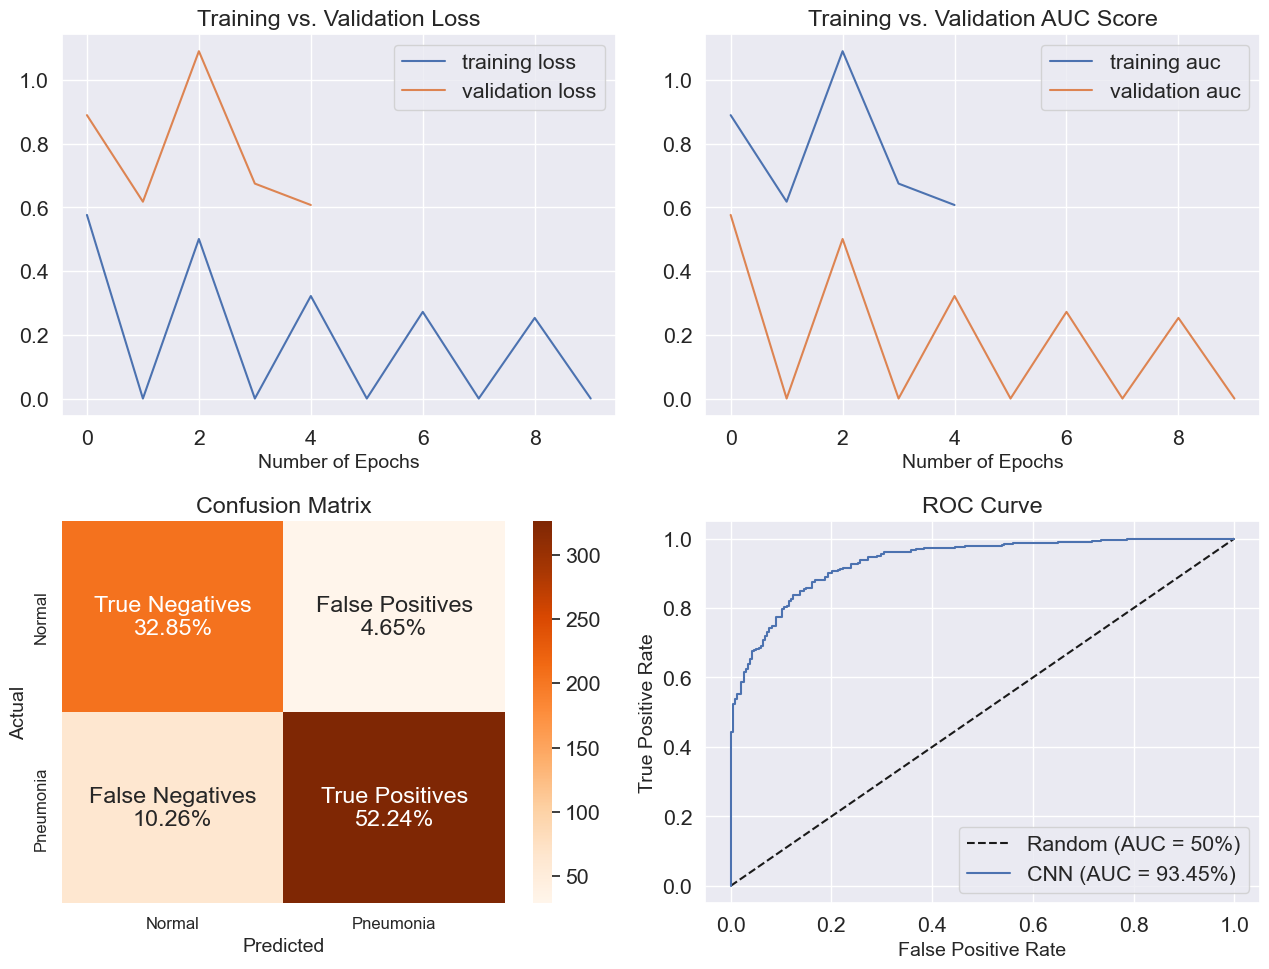

In [149]:
create_charts(cnn, cnn_model)

### Model #3: Conv2D x 2 + 64 dense units

In [150]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

# Replaced fit_generator with fit method
cnn_model = cnn.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=10, 
                    validation_data=val_generator,
                    validation_steps=len(val_generator), 
                    verbose=2)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
41/41 - 29s - 717ms/step - auc_29: 0.7409 - loss: 0.5066 - val_auc_29: 0.9219 - val_loss: 0.6044
Epoch 2/10
41/41 - 0s - 1ms/step - auc_29: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 - 28s - 681ms/step - auc_29: 0.9368 - loss: 0.2839 - val_auc_29: 0.9688 - val_loss: 0.3300
Epoch 4/10
41/41 - 0s - 808us/step - auc_29: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
41/41 - 29s - 715ms/step - auc_29: 0.9599 - loss: 0.2247 - val_auc_29: 0.9844 - val_loss: 0.3091
Epoch 6/10
41/41 - 0s - 1ms/step - auc_29: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
41/41 - 28s - 674ms/step - auc_29: 0.9654 - loss: 0.2070 - val_auc_29: 0.9766 - val_loss: 0.6109
Epoch 8/10
41/41 - 0s - 984us/step - auc_29: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
41/41 - 28s - 677ms/step - auc_29: 0.9665 - loss: 0.2017 - val_auc_29: 0.9688 - val_loss: 0.6199
Epoch 10/10
41/41 - 0s - 832us/step - auc_29: 0.0000e+00 - loss: 0.0000e+00


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step
[Summary Statistics]
Accuracy = 84.46% | Precision = 81.78% | Recall = 96.67% | Specificity = 64.10% | F1 Score = 88.60%


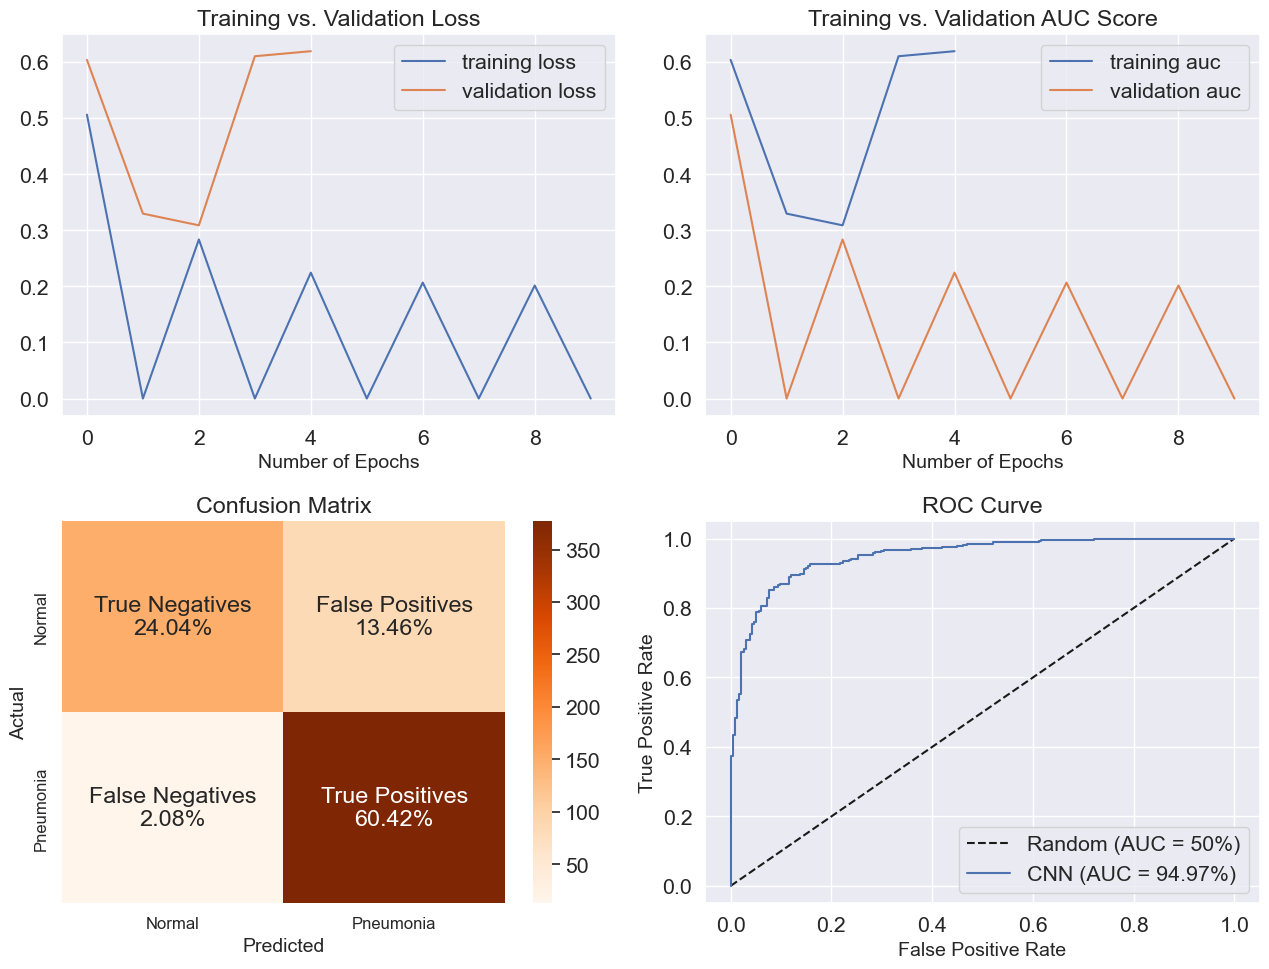

In [151]:
create_charts(cnn, cnn_model)

### Model #4 (I): Conv2D x 3 + 128 dense units (100 epochs)

In [152]:
# Define the number of feature maps (filters) for Conv2D layers
hyper_feature_maps = 32  # Example value, you can change it as needed

cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=10, 
                    validation_data=val_generator,
                    validation_steps=len(val_generator), 
                    verbose=2)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
41/41 - 29s - 701ms/step - auc_30: 0.5335 - loss: 0.5781 - val_auc_30: 0.5781 - val_loss: 0.7854
Epoch 2/10
41/41 - 0s - 1ms/step - auc_30: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 - 28s - 683ms/step - auc_30: 0.8719 - loss: 0.3953 - val_auc_30: 0.8438 - val_loss: 0.5389
Epoch 4/10
41/41 - 0s - 703us/step - auc_30: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
41/41 - 27s - 649ms/step - auc_30: 0.9250 - loss: 0.2992 - val_auc_30: 0.8594 - val_loss: 0.4731
Epoch 6/10
41/41 - 0s - 540us/step - auc_30: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
41/41 - 26s - 638ms/step - auc_30: 0.9471 - loss: 0.2557 - val_auc_30: 0.8906 - val_loss: 0.4907
Epoch 8/10
41/41 - 0s - 545us/step - auc_30: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
41/41 - 29s - 709ms/step - auc_30: 0.9625 - loss: 0.2156 - val_auc_30: 0.8672 - val_loss: 0.5734
Epoch 10/10
41/41 - 0s - 623us/step - auc_30: 0.0000e+00 - loss: 0.0000e+00


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step
[Summary Statistics]
Accuracy = 87.82% | Precision = 87.38% | Recall = 94.10% | Specificity = 77.35% | F1 Score = 90.62%


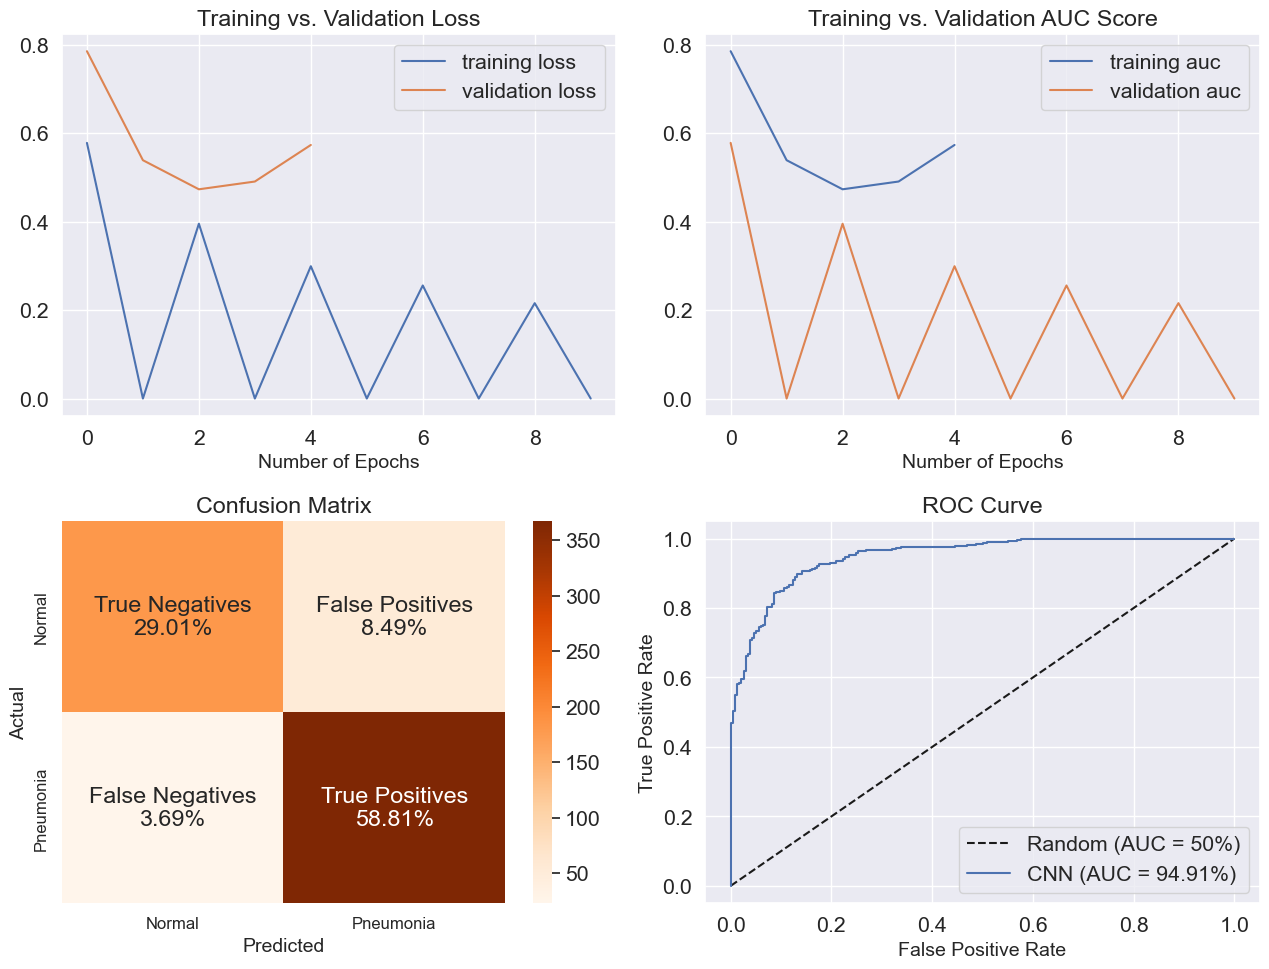

In [153]:
create_charts(cnn, cnn_model)

### Model #4 (II): Conv2D x 3 + 128 dense units (200 epochs)

In [154]:
# Define the number of feature maps (filters) for Conv2D layers
hyper_feature_maps = 32  # Example value, you can change it as needed

cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=20, 
                    validation_data=val_generator,
                    validation_steps=len(val_generator), 
                    verbose=2)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
41/41 - 30s - 743ms/step - auc_31: 0.5626 - loss: 0.5721 - val_auc_31: 0.6250 - val_loss: 0.7242
Epoch 2/20
41/41 - 0s - 1ms/step - auc_31: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 - 28s - 674ms/step - auc_31: 0.8588 - loss: 0.4118 - val_auc_31: 0.8750 - val_loss: 0.5810
Epoch 4/20
41/41 - 0s - 632us/step - auc_31: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
41/41 - 30s - 735ms/step - auc_31: 0.9459 - loss: 0.2583 - val_auc_31: 0.8906 - val_loss: 1.4951
Epoch 6/20
41/41 - 0s - 918us/step - auc_31: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
41/41 - 27s - 669ms/step - auc_31: 0.9462 - loss: 0.2559 - val_auc_31: 0.8828 - val_loss: 0.6861
Epoch 8/20
41/41 - 0s - 847us/step - auc_31: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
41/41 - 29s - 706ms/step - auc_31: 0.9597 - loss: 0.2218 - val_auc_31: 0.8750 - val_loss: 0.4462
Epoch 10/20
41/41 - 0s - 673us/step - auc_31: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
41/41 - 28s - 673ms/step - auc_31: 0.9623 - loss: 0.2156 - val_auc_31: 0.8750 - val_loss: 0.4721
Epoch 12/20
41/41 - 0s - 911us/step - auc_31: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/20
41/41 - 27s - 671ms/step - auc_31: 0.9687 - loss: 0.1981 - val_auc_31: 0.9062 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step
[Summary Statistics]
Accuracy = 90.87% | Precision = 89.18% | Recall = 97.18% | Specificity = 80.34% | F1 Score = 93.01%


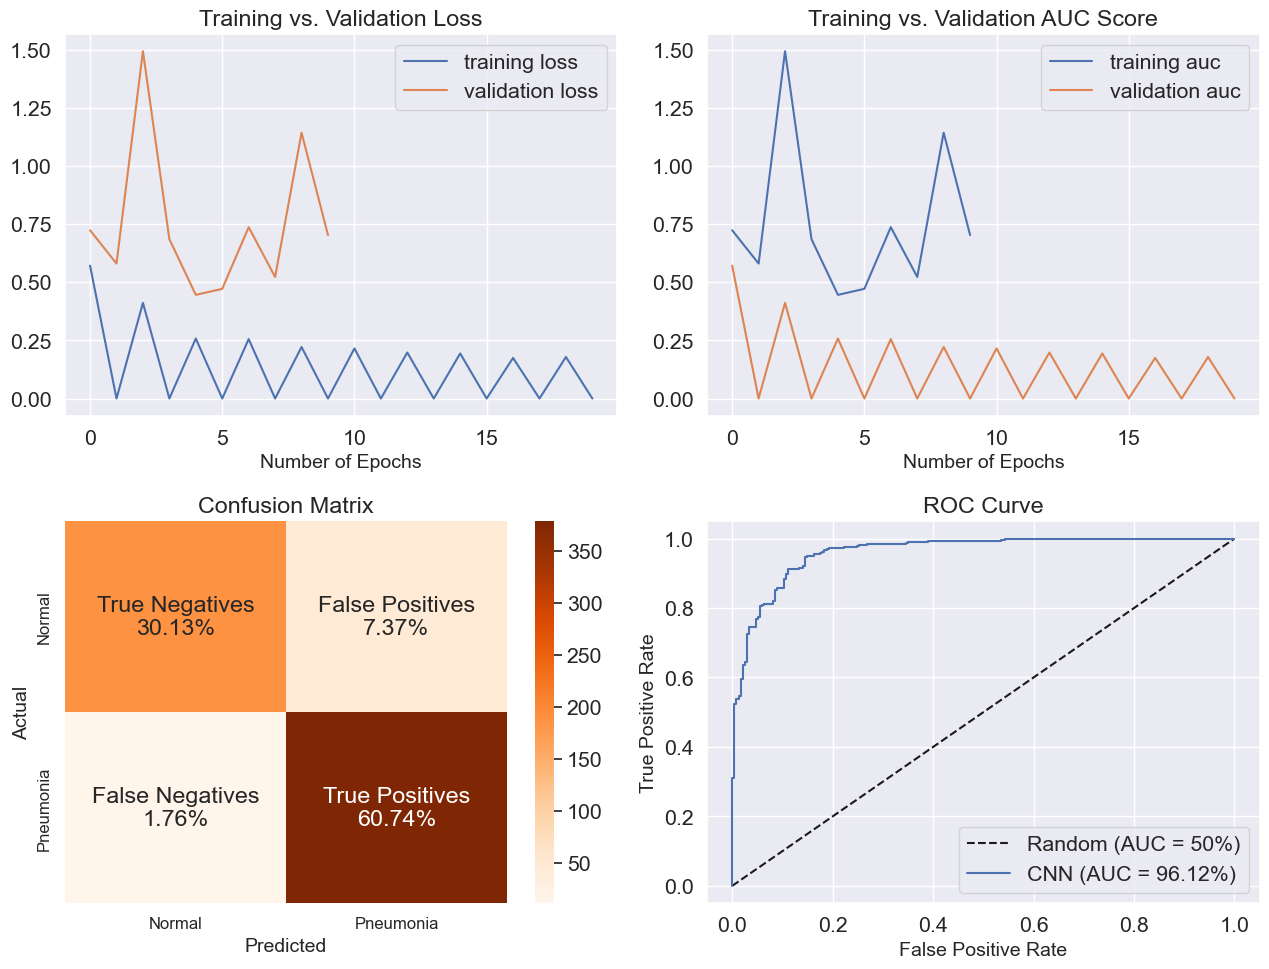

In [155]:
create_charts(cnn, cnn_model)

### Model #5

In [156]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=64, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=128, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(activation='relu', units=1024))
cnn.add(Dense(activation='relu', units=512))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator,  # Use 'fit' instead of 'fit_generator'
                    steps_per_epoch=len(train_generator), 
                    epochs=10, 
                    validation_data=val_generator,
                    validation_steps=len(val_generator), 
                    verbose=2)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
41/41 - 35s - 849ms/step - auc_32: 0.9508 - loss: 0.2601 - val_auc_32: 0.8750 - val_loss: 0.6596
Epoch 2/10
41/41 - 0s - 3ms/step - auc_32: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 - 31s - 747ms/step - auc_32: 0.9766 - loss: 0.1689 - val_auc_32: 0.6641 - val_loss: 0.7598
Epoch 4/10
41/41 - 0s - 1ms/step - auc_32: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
41/41 - 32s - 789ms/step - auc_32: 0.9827 - loss: 0.1445 - val_auc_32: 0.8828 - val_loss: 0.6452
Epoch 6/10
41/41 - 0s - 2ms/step - auc_32: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
41/41 - 31s - 752ms/step - auc_32: 0.9840 - loss: 0.1333 - val_auc_32: 0.9297 - val_loss: 0.6415
Epoch 8/10
41/41 - 0s - 1ms/step - auc_32: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
41/41 - 31s - 750ms/step - auc_32: 0.9861 - loss: 0.1238 - val_auc_32: 0.9375 - val_loss: 0.7689
Epoch 10/10
41/41 - 0s - 1ms/step - auc_32: 0.0000e+00 - loss: 0.0000e+00


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step
[Summary Statistics]
Accuracy = 62.50% | Precision = 62.50% | Recall = 100.00% | Specificity = 0.00% | F1 Score = 76.92%


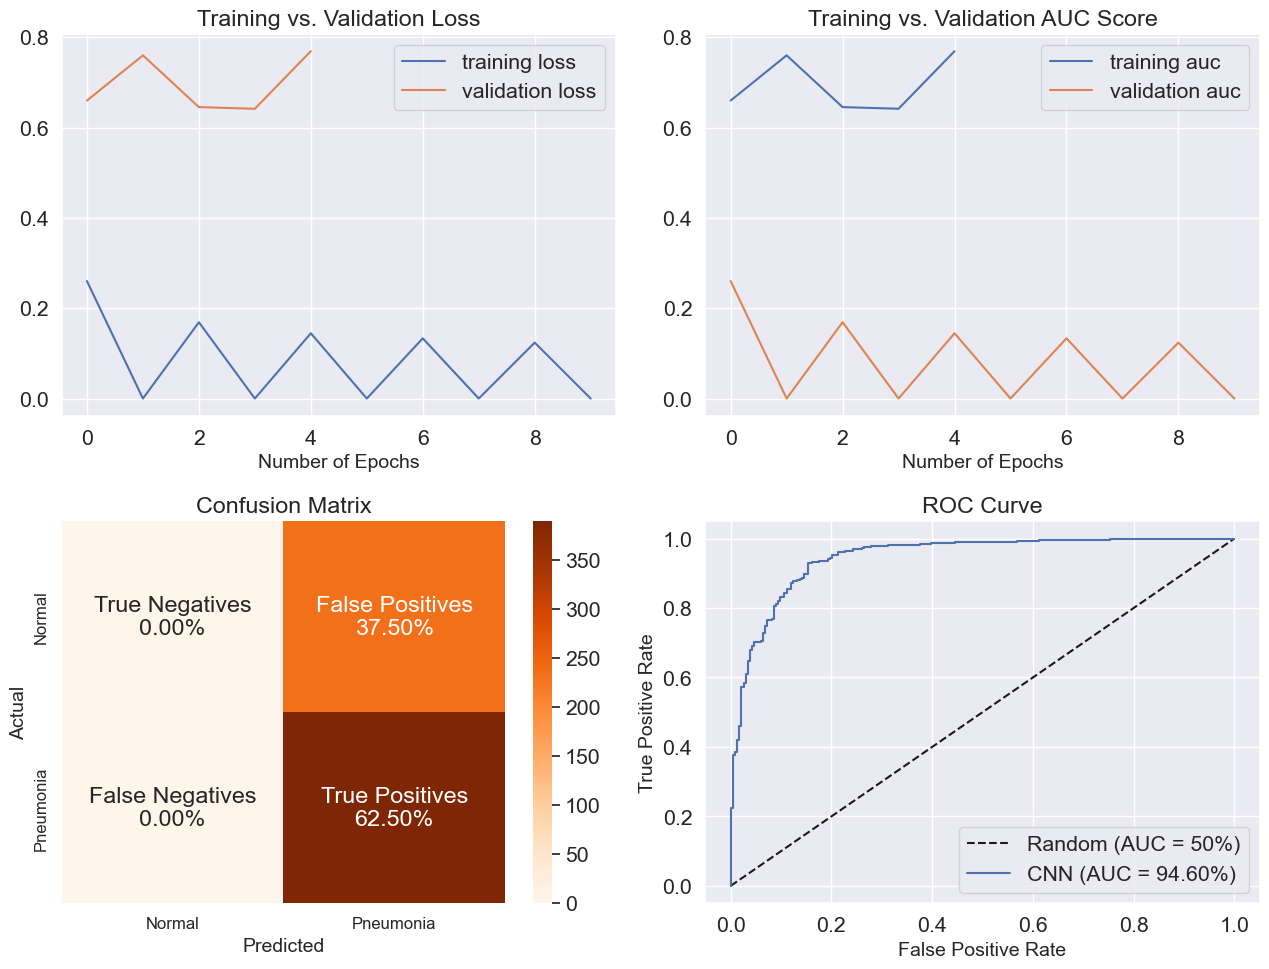

In [157]:
create_charts(cnn, cnn_model)

### Model #6

In [158]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=64, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(filters=128, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(activation='relu', units=512))
cnn.add(Dropout(0.25))
cnn.add(Dense(activation='relu', units=256))
cnn.add(Dropout(0.25))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator,  # Use 'fit' instead of 'fit_generator'
                    steps_per_epoch=len(train_generator), 
                    epochs=10, 
                    validation_data=val_generator,
                    validation_steps=len(val_generator), 
                    verbose=2)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
41/41 - 35s - 846ms/step - auc_33: 0.8480 - loss: 0.4138 - val_auc_33: 0.6172 - val_loss: 0.6783
Epoch 2/10
41/41 - 0s - 2ms/step - auc_33: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 - 32s - 793ms/step - auc_33: 0.9385 - loss: 0.2724 - val_auc_33: 0.8984 - val_loss: 0.7684
Epoch 4/10
41/41 - 0s - 760us/step - auc_33: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
41/41 - 31s - 759ms/step - auc_33: 0.9527 - loss: 0.2405 - val_auc_33: 0.8984 - val_loss: 0.9003
Epoch 6/10
41/41 - 0s - 590us/step - auc_33: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
41/41 - 32s - 788ms/step - auc_33: 0.9652 - loss: 0.2064 - val_auc_33: 0.9141 - val_loss: 1.1757
Epoch 8/10
41/41 - 0s - 527us/step - auc_33: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
41/41 - 59s - 1s/step - auc_33: 0.9708 - loss: 0.1867 - val_auc_33: 0.9375 - val_loss: 0.6975
Epoch 10/10
41/41 - 0s - 5ms/step - auc_33: 0.0000e+00 - loss: 0.0000e+00


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 
[Summary Statistics]
Accuracy = 65.06% | Precision = 64.14% | Recall = 100.00% | Specificity = 6.84% | F1 Score = 78.16%


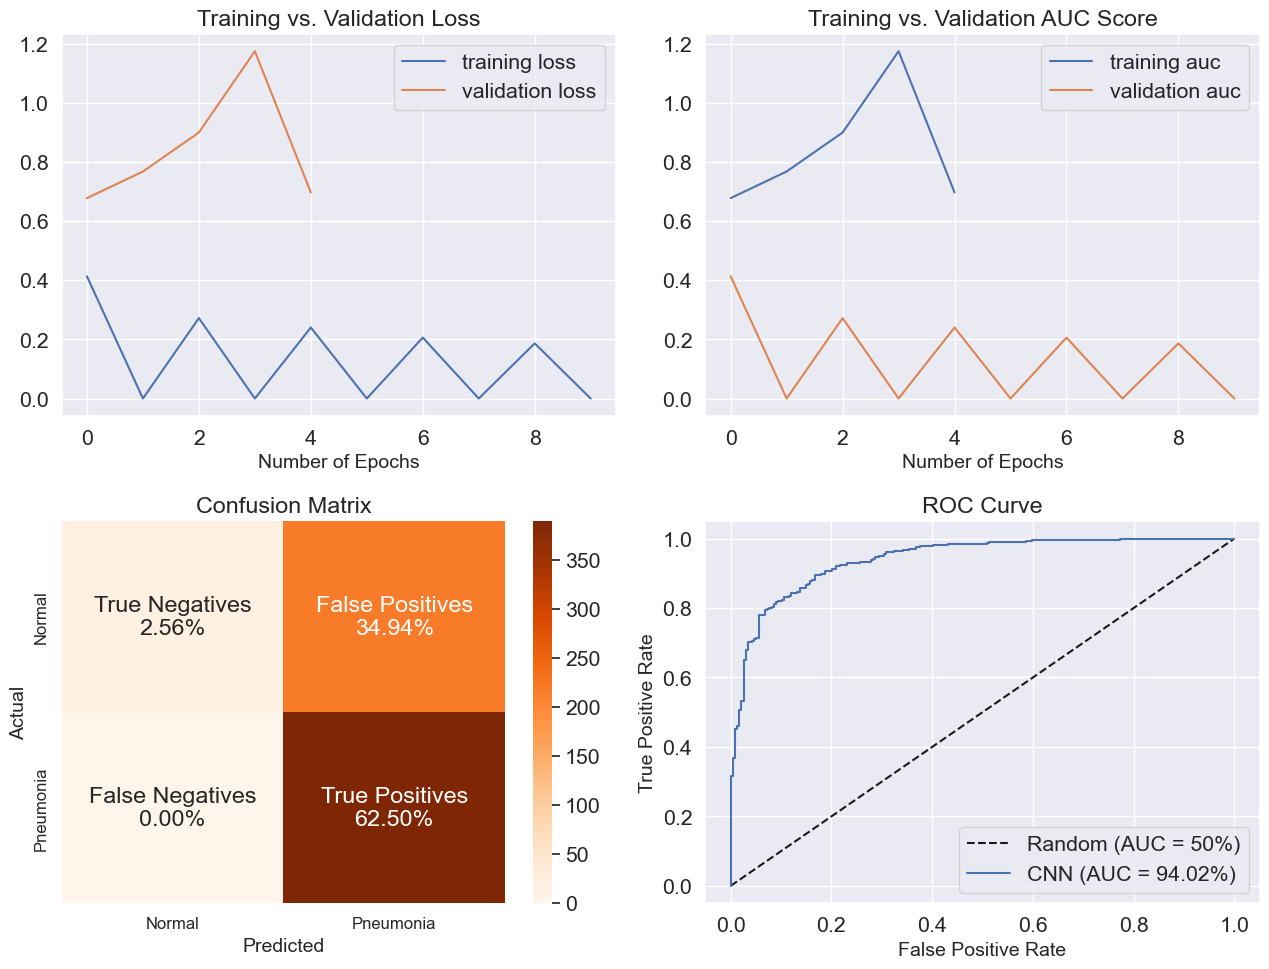

In [159]:
create_charts(cnn, cnn_model)